In [1]:
import folium
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shapefile
import pickle
import random
import gams_magic
import networkx as nx

In [2]:
# read link data
road_file_path = os.path.join('..','road_file.csv')
road_file = pd.read_csv(road_file_path,names=["RDWY_LINK_ID","REF_SITE_FROM_ID","REF_SITE_TO_ID"])

# read road shape (shape file already converted using CRS in qgis)
shape_path = os.path.join("..","transportation_data","Middleton_Cross_Plains","Features","Middleton_Road_New.shp")
shape = shapefile.Reader(shape_path)

# read crash shape
crash_path = os.path.join("..","transportation_data","Middleton_Cross_Plains","Features","Crash_data_combined_2017_2020.shp")
crash = shapefile.Reader(crash_path)

# load reference point coordinate
reference_coordinate = None
reference_path = os.path.join("..","reference_coordinate")

with open(reference_path, 'rb') as f:
    reference_coordinate = pickle.load(f)

In [3]:
idToRoad =  []
with open("../turning_network_linkID_updated.csv",'r') as f:
    idToRoad = csv.reader(f)
    idToRoad = list(idToRoad)
    
idToRoadDict = {}
roadToIdDict ={}
for element in idToRoad:
    idToRoadDict[element[0]] = (element[1],element[2])
    if "intersection" not in element[0]:
        roadToIdDict[element[1].split('_')[0],element[2].split('_')[0]] = element[0]

# Start Model

We formulate network flow problem as Mix Integer Programming to solve for different objective choices. The objectives include the following.
1. Minimizing traveling time
2. Minimizing number of turns
3. Minimizing raw crash data
4. Minimizing adjusted crash data
5. Intermediate Model between minimizing traveling time and adjusted crash data



$V \text{: set of all network nodes}$

$W \text{: choice of weight on each road (ex. traveling time or adjust crash data weight)}$

$o \text{: a vertex chosen as starting point}$

$d \text{: a vertex chosen as destination point}$

$f_{ij} \text{: 1 if road from node i to j is chosen}, i,j\in V$


$$
\min_{f} \sum_{e \in E} f_e W_e \tag{1}
$$



$$
\text{s.t.} \sum_{j : (i,j)\in E} f_{ij} - \sum_{j : (j,i)\in E} f_{ji} = 0, \forall i \in V\setminus\{o,d\} \tag{2}
$$

$$
\sum_{j : (i,j)\in E} f_{ij} - \sum_{j : (j,i)\in E} f_{ji} = 1, i = o \tag{3}
$$

$$
\sum_{j : (i,j)\in E} f_{ij} - \sum_{j : (j,i)\in E} f_{ji} = 1, i = d \tag{4}
$$


Different objectives in our model are implemented by using different weights $W_e$.

## Weighted

In [103]:
%reload_ext gams_magic
%gams_cleanup -k
%gams_reset

In [104]:
%%gams

$title network

option limcol = 0, limrow = 0, solprint = off;
set
    nodes
    roadID
    season
    seriousness
;

alias (nodes,i,j);

* load traveling time on network
$gdxin ../turning_network_time_updated.gdx
$loadm nodes=dim1 nodes=dim2
parameter real_distance(nodes,nodes) distance of a road;
$load  real_distance=time
$gdxin

* load turn data
$gdxin ../turning_network_turn_updated.gdx
parameter turn(nodes,nodes) distance of a road;
$load  turn=turn
$gdxin


* load updated risk factor
$gdxin ../crash_drisk0320.gdx
parameter risk(nodes,nodes) distance of a road;
$load  risk=drisk
$gdxin

* load crash count
$gdxin ../crash_count0320.gdx
parameter count(nodes,nodes) distance of a road;
$load  count=count
$gdxin



$gdxin ../turning_network_linkID_updated.gdx
set road(roadID<,i,j);
$load  road=road
$gdxin



parameter distance(nodes,nodes);

distance(i,j) = real_distance(i,j);

real_distance(i,j) = real_distance(i,j) + turn(i,j) - 1;

set arc(nodes,nodes);

arc(i,j) = no;
arc(i,j)$(distance(i,j) > 0.5) = yes;
* adjust the distance
distance(i,j)$(arc(i,j)) = distance(i,j) -1;

scalar
    turn_const /100/
    intermediate_val /10/
    Lambda /0.1/;
;

parameter
    supply(nodes)
;

scalar origin,destination;
execseed = 1 + gmillisec(jnow);
origin = uniformint(1,card(nodes));
destination = uniformint(1,card(nodes));

*supply(nodes)$(ord(nodes) = origin) = 1;

*supply(nodes)$(ord(nodes) = destination) = -1;


* starting point for paper
 supply('1666494_2') = 1;


* ending point for paper
 supply('1662728_3') = -1;

*supply('1664156_1') = 1;
*supply('2212306_1') = -1;

*supply('10949_1') = 1;
*supply('2212306_1') = -1;


free variable
    total_dist
;

integer variable
    flow(i,j)
;

flow.lo(i,j) = 0

equation
    balance(nodes)
    objective_shortestPath
    objective_safestPath
    objective_shortestPath2
    objective_short "shortest path formulation"
    intermediate_constr
    turn_constr
;


balance(i)..
    sum(arc(i,j), flow(i,j)) - sum(arc(j,i), flow(j,i)) =e= supply(i);
    
objective_short..
    total_dist =e= sum(arc(i,j),flow(i,j)*distance(i,j));
**********************************************************

intermediate_constr..
    sum(arc(i,j),flow(i,j)*risk(i,j)) =l= intermediate_val;
********************************************************** 

objective_shortestPath..
    total_dist =e= sum(arc(i,j),flow(i,j)*turn(i,j));

objective_shortestPath2..
    total_dist =e= sum(arc(i,j),Lambda*flow(i,j)*distance(i,j) + (1-Lambda)*flow(i,j)*risk(i,j));
    


    
turn_constr..
    sum(arc(i,j),flow(i,j)*turn(i,j)) =l= turn_const;



model weighted /balance, objective_shortestPath2/;


** stochastic component
parameter  stochastic(i,j), stochastic2(i,j);
scalar stochasticLambda;
stochastic(i,j) = uniform(0.2,1.8);
stochastic2(i,j) = uniform(0.2,1.8);
stochasticLambda = uniform(0,1);


*** intermediate model

scalar paretoRatioDistance, paretoRatioRisk, paretoRatioIntermediate;

*distance(i,j) = real_distance(i,j);
distance(i,j) = real_distance(i,j)*stochastic(i,j);
risk(i,j) = risk(i,j) * stochastic2(i,j);

*intermediate_val = (0.2*roadChosenDistance_risk+1.8*roadChosenRisk_risk)/2;


Lambda = 0.2;

solve weighted using mip minimizing total_dist;

paretoRatioIntermediate = sum(arc(i,j),flow.l(i,j)*risk(i,j))/sum(arc(i,j),flow.l(i,j)*distance(i,j))

set roadChosenIntermediate(roadID);

roadChosenIntermediate(roadID)$( sum(road(roadID,i,j), flow.l(i,j)) > 0.5) = yes;
roadChosenIntermediate(roadID)$( sum(road(roadID,i,j), flow.l(j,i)) > 0.5) = yes;


Lambda = 1;

solve weighted using mip minimizing total_dist;

paretoRatioDistance = sum(arc(i,j),flow.l(i,j)*risk(i,j))/sum(arc(i,j),flow.l(i,j)*distance(i,j))
set roadChosenDistance(roadID);

roadChosenDistance(roadID)$( sum(road(roadID,i,j), flow.l(i,j)) > 0.5) = yes;
roadChosenDistance(roadID)$( sum(road(roadID,i,j), flow.l(j,i)) > 0.5) = yes;

Lambda = 0;


solve weighted using mip minimizing total_dist;


paretoRatioRisk = sum(arc(i,j),flow.l(i,j)*risk(i,j))/sum(arc(i,j),flow.l(i,j)*distance(i,j))
set roadChosenRisk(roadID);

roadChosenRisk(roadID)$( sum(road(roadID,i,j), flow.l(i,j)) > 0.5) = yes;
roadChosenRisk(roadID)$( sum(road(roadID,i,j), flow.l(j,i)) > 0.5) = yes;



,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),1757.7580,3211,9043,MIP,CPLEX,0.468
1,Normal (1),Optimal Global (1),1402.6785,3211,9043,MIP,CPLEX,0.17
2,Normal (1),Optimal Global (1),1590.4669,3211,9043,MIP,CPLEX,0.145


In [105]:
%gams_pull roadChosenRisk
%gams_pull roadChosenIntermediate
%gams_pull roadChosenDistance
%gams_pull paretoRatioRisk 
%gams_pull paretoRatioDistance
%gams_pull paretoRatioIntermediate
%gams_pull supply

In [106]:
print(paretoRatioDistance,paretoRatioIntermediate,paretoRatioRisk)

[18.2551662629109] [0.7344711817011057] [0.582288829687126]


In [107]:
# get the chosen road
chosen_road_risk = []
# chosen_road_count = []
chosen_road_distance = []
# chosen_road_turn = []
chosen_road_intermediate = []
for link in roadChosenRisk:
    if "intersection" not in link:
        chosen_road_risk.append(int(link)) 
        
# for link in roadChosenCount:
#     if "intersection" not in link:
#         chosen_road_count.append(int(link))
                                 
for link in roadChosenDistance:
    if "intersection" not in link:
        chosen_road_distance.append(int(link))
        
# for link in roadChosenTurn:
#     if "intersection" not in link:
#         chosen_road_turn.append(int(link))
        
for link in roadChosenIntermediate:
    if "intersection" not in link:
        chosen_road_intermediate.append(int(link))

#chosen_road_intermediate = trajDict['l1']
                                    
# get the chosen origin and destination
origin = None
destination = None
for i in supply:
    if i[1] == 1:
        origin = int(i[0].split("_")[0])
    else:
        destination = int(i[0].split("_")[0])

In [108]:
plt.rcParams["figure.figsize"] = (20,10)
plt.figure()

    
chosen_risk = []
# chosen_count = []
chosen_distance = []
# chosen_turn = []
chosen_intermediate = []
#plot original map 
for sp in shape.shapeRecords():
    road_id = sp.record[43]

    x = [i[0] for i in sp.shape.points[:]]
    y = [i[1] for i in sp.shape.points[:]]
        
    #record chosen road
    if road_id in chosen_road_risk:
        segment = []
        for i in range(len(x)):
                segment.append((y[i],x[i]))
        chosen_risk.append(segment)
        
    if road_id in chosen_road_distance:
        segment = []
        for i in range(len(x)):
                segment.append((y[i],x[i]))
        chosen_distance.append(segment)
        
    if road_id in chosen_road_intermediate:
        segment = []
        for i in range(len(x)):
                segment.append((y[i],x[i]))
        chosen_intermediate.append(segment)
        

<Figure size 1440x720 with 0 Axes>

In [110]:
m = folium.Map(location=[43.0819, -89.5579])

# for loc in chosen_risk:
#     folium.PolyLine(loc,
#                 color='red',
#                 weight=8,
#                 opacity=0.8).add_to(m)
    
    
# for loc in chosen_distance:
#     folium.PolyLine(loc,
#                 color='green',
#                 weight=6,
#                 opacity=0.8).add_to(m)


for loc in chosen_intermediate:
    folium.PolyLine(loc,
                color='purple',
                weight=3,
                opacity=0.8).add_to(m)
m

# test gams loop

In [57]:
%reload_ext gams_magic
%gams_cleanup -k
%gams_reset

In [ ]:
%gams_pull roadChosenIntermediate
%gams_pull supply

In [ ]:
# How many trajectories are there?
trajectoryNum = 100

# Create a dictionary to store route output for every trajectories
trajDict = {}
trajDictShape = {} # stores the roads shape for plotting
trajNames = []
for i in range(trajectoryNum):
    s = 'l' + str(i+1)
    trajNames.append(s)
    trajDict[s] = []
    trajDictShape[s] = []
for r in roadChosenIntermediate:
    if 'intersection' not in r[0]:
        trajDict[r[1]].append(int(r[0]))
        
# store the origin and destination       
origin = None
destination = None
for i in supply:
    if i[1] == 1:
        origin = int(i[0].split("_")[0])
    else:
        destination = int(i[0].split("_")[0])

In [63]:
for sp in shape.shapeRecords():
    road_id = sp.record[43] 

    x = [i[0] for i in sp.shape.points[:]]
    y = [i[1] for i in sp.shape.points[:]]
        
    #record chosen road
    if road_id in chosen_road_risk:
        segment = []
        for i in range(len(x)):
                segment.append((y[i],x[i]))
        chosen_risk.append(segment)
    
#     if road_id in chosen_road_count:
#         segment = []
#         for i in range(len(x)):
#                 segment.append((y[i],x[i]))
#         chosen_count.append(segment)
        
    if road_id in chosen_road_distance:
        segment = []
        for i in range(len(x)):
                segment.append((y[i],x[i]))
        chosen_distance.append(segment)
        
#     if road_id in chosen_road_turn:
#         segment = []
#         for i in range(len(x)):
#                 segment.append((y[i],x[i]))
#         chosen_turn.append(segment)
        
    if road_id in chosen_road_intermediate:
        segment = []
        for i in range(len(x)):
                segment.append((y[i],x[i]))
        chosen_intermediate.append(segment)
        

In [64]:
m = folium.Map(location=[43.0819, -89.5579])

for loop in trajNames:
    for loc in trajDictShape[loop]:
        folium.PolyLine(loc,
                    color='black',
                    weight=1,
                    opacity=0.8).add_to(m)



In [65]:
m

In [59]:
roadChosenIntermediate

[['intersection_64', 'l1'],
 ['intersection_64', 'l2'],
 ['intersection_64', 'l3'],
 ['intersection_64', 'l4'],
 ['intersection_64', 'l5'],
 ['intersection_68', 'l1'],
 ['intersection_68', 'l2'],
 ['intersection_68', 'l3'],
 ['intersection_68', 'l4'],
 ['intersection_68', 'l5'],
 ['intersection_181', 'l5'],
 ['intersection_185', 'l5'],
 ['intersection_242', 'l1'],
 ['intersection_244', 'l2'],
 ['intersection_244', 'l3'],
 ['intersection_249', 'l2'],
 ['intersection_249', 'l3'],
 ['intersection_251', 'l1'],
 ['intersection_286', 'l2'],
 ['intersection_286', 'l3'],
 ['intersection_286', 'l4'],
 ['intersection_289', 'l2'],
 ['intersection_289', 'l3'],
 ['intersection_289', 'l4'],
 ['intersection_316', 'l2'],
 ['intersection_317', 'l1'],
 ['intersection_317', 'l3'],
 ['intersection_317', 'l4'],
 ['intersection_317', 'l5'],
 ['intersection_318', 'l2'],
 ['intersection_319', 'l2'],
 ['intersection_320', 'l2'],
 ['intersection_321', 'l1'],
 ['intersection_321', 'l3'],
 ['intersection_321', 'l

# Import random global trajectories

In [41]:
trajectory_list = None
with open("trajectories_500.csv",'r') as f:
    reader = csv.reader(f)
    trajectory_list = list(reader)

In [42]:
roadChosenIntermediate = trajectory_list[1:]

In [43]:
# How many trajectories are there?
trajectoryNum = 500

# Create a dictionary to store route output for every trajectories
trajDict = {}
trajDictShape = {} # stores the roads shape for plotting
trajNames = []
for i in range(trajectoryNum):
    s = 'l' + str(i+1)
    trajNames.append(s)
    trajDict[s] = []
    trajDictShape[s] = []
    
for r in roadChosenIntermediate:
    if 'intersection' not in r[0]:
        trajDict[r[1]].append(int(r[0]))
        


In [6]:
# create road shape dictionary
road_vector = {}
for sp in shape.shapeRecords():
    # different road shape can share the same road id
    road_id = sp.record[43]
    

    x = [i[0] for i in sp.shape.points[:]]
    y = [i[1] for i in sp.shape.points[:]]
    
    segment = []
    for i in range(len(x)):
        segment.append((y[i],x[i]))
        
    if road_id in road_vector:
        road_vector[road_id].append(segment)
    else:
        road_vector[road_id] = [segment]

In [45]:
for loop in trajNames:
    for road_id in trajDict[loop]:
        trajDictShape[loop] += road_vector[road_id]

In [10]:
def rgb_to_hex(r, g, b):
    return ('#{:X}{:X}{:X}').format(r, g, b)

print(rgb_to_hex(255, 165, 1))

#FFA51


In [47]:
group = [3, 3, 0, 0, 0, 0, 0, 3, 3, 3, 0, 1, 1, 0, 3, 3, 0, 0, 0, 0, 0, 3,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 3, 3, 3, 3,
       3, 3, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 3, 3, 0, 0, 3, 0, 0, 1, 0, 1, 3, 3, 0, 0,
       3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 2, 3, 2, 0, 2, 3, 3, 0, 0, 0, 2, 2, 0, 2, 2, 3, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2,
       0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 2, 2, 2, 2, 2, 4, 4, 2,
       2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 4, 2, 2, 2,
       2, 4, 4, 2, 2, 2, 2, 2, 4, 2, 4, 2, 2, 2, 4, 2, 2, 2, 4, 2, 2, 2,
       2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 2, 2, 2, 4, 2, 2,
       2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [48]:
color_list = []
for i in range(5):
    color_list.append(rgb_to_hex(random.randint(1,256), random.randint(1,256), random.randint(1,256)))

In [81]:
m = folium.Map(location=[43.0819, -89.5579])

#for loop in trajNames:
ind = 0 
for loop in trajNames:
    for loc in trajDictShape[loop]:
        if group[ind] ==0:
            folium.PolyLine(loc,
                        #color=rgb_to_hex(random.randint(1,256), random.randint(1,256), random.randint(1,256)),
                        color=rgb_to_hex(128, 128, 128),
                        weight=1.5,
                        opacity=0.8).add_to(m)
    ind += 1
    
m.save("group0.html")

In [55]:
m = folium.Map(location=[43.0819, -89.5579])

#for loop in trajNames:
ind = 0 
for loop in trajNames:
    for loc in trajDictShape[loop]:
        if group[ind] ==1:
            folium.PolyLine(loc,
                        #color=rgb_to_hex(random.randint(1,256), random.randint(1,256), random.randint(1,256)),
                        color='red',
                        weight=1.5,
                        opacity=0.8).add_to(m)
    ind += 1
    
m.save("group1.html")

In [56]:
m = folium.Map(location=[43.0819, -89.5579])

#for loop in trajNames:
ind = 0 
for loop in trajNames:
    for loc in trajDictShape[loop]:
        if group[ind] ==2:
            folium.PolyLine(loc,
                        #color=rgb_to_hex(random.randint(1,256), random.randint(1,256), random.randint(1,256)),
                        color='green',
                        weight=1.5,
                        opacity=0.8).add_to(m)
    ind += 1
    
m.save("group2.html")

In [57]:
m = folium.Map(location=[43.0819, -89.5579])

#for loop in trajNames:
ind = 0 
for loop in trajNames:
    for loc in trajDictShape[loop]:
        if group[ind] ==3:
            folium.PolyLine(loc,
                        #color=rgb_to_hex(random.randint(1,256), random.randint(1,256), random.randint(1,256)),
                        color='blue',
                        weight=1.5,
                        opacity=0.8).add_to(m)
    ind += 1
    
m.save("group3.html")

In [58]:
m = folium.Map(location=[43.0819, -89.5579])

#for loop in trajNames:
ind = 0 
for loop in trajNames:
    for loc in trajDictShape[loop]:
        if group[ind] ==4:
            folium.PolyLine(loc,
                        #color=rgb_to_hex(random.randint(1,256), random.randint(1,256), random.randint(1,256)),
                        color='black',
                        weight=1.5,
                        opacity=0.8).add_to(m)
    ind += 1
    
m.save("group4.html")

## Visualize chosen road for each group

In [17]:
with open("group_5_optimal_path_L_filtered_2.pk", 'rb') as f:
    group_optimal_path = pickle.load(f)

In [18]:
optimal_roadIdList = []
for g in range(5):
    example_coordinate = []
    for ind in range(len(group_optimal_path[g])-1):
            #print((example_trip[ind],example_trip[ind+1]))
            example_coordinate += road_vector[int(roadToIdDict[group_optimal_path[g][ind],group_optimal_path[g][ind+1]])]    
    optimal_roadIdList.append(example_coordinate)


In [20]:

colors = [rgb_to_hex(128, 128, 128),'red','green','blue','black']
#for loop in trajNames:
# for loop in trajNames:
for g in range(5):
    m = folium.Map(location=[43.0819, -89.5579])
    for loc in optimal_roadIdList[g]:
        folium.PolyLine(loc,
                    #color=rgb_to_hex(random.randint(1,256), random.randint(1,256), random.randint(1,256)),
                    color=colors[g],
                    weight=5.5-1*g,
                    opacity=0.8).add_to(m)

    
    m.save("optimal_paths_group{}_L_filtered_2.html".format(g))

In [92]:
colors[4]

'#111'

In [76]:
road_vector[int(roadToIdDict['1666498','1666494'])]

[[(43.06048031910156, -89.62565265556754),
  (43.060485814574406, -89.62604176119129),
  (43.060498894049154, -89.62729351679035),
  (43.06052749102025, -89.62873323399825),
  (43.0605458264783, -89.63022443364672),
  (43.06056615989565, -89.63173250825074),
  (43.06058986568248, -89.63324819010636)]]

In [74]:
road_vector.keys()

dict_keys([4840779, 4840771, 4840767, 4828136, 5314065, 5314061, 5314060, 5313825, 5313814, 4850816, 5314296, 4827455, 5372932, 4819393, 4819383, 5321249, 5314545, 5372931, 5341804, 5313813, 5313831, 5313824, 5313820, 5314164, 4819381, 4848815, 4827430, 5313828, 5314163, 5314295, 4819385, 4849521, 5314066, 5313819, 5314337, 5314080, 4829431, 4848840, 5314731, 5314540, 5314081, 5314757, 5313832, 5313827, 5341805, 5284159, 4840769, 5284158, 5321342, 5454898, 5454897, 5455236, 5455235, 5455234, 5455233, 4824866, 4824879, 4824906, 4824908, 4825071, 4825190, 4826251, 4830819, 4830830, 4846252, 4846265, 4846292, 4846294, 4846457, 4846576, 4847636, 4852204, 4852215, 4829428, 4829429, 4850813, 4850814, 4819276, 4819507, 4820033, 4820708, 4830617, 4840662, 4840893, 4841419, 4842094, 4852002, 4821060, 4842446, 4828126, 4849511, 4819304, 4819355, 4819408, 4819692, 4840690, 4840741, 4840794, 4841078, 4819008, 4819111, 4819240, 4819284, 4819339, 4819340, 4819364, 4819370, 4819373, 4819403, 4819426,

In [ ]:
idToRoad =  []
with open("../turning_network_linkID_updated.csv",'r') as f:
    idToRoad = csv.reader(f)
    idToRoad = list(idToRoad)
    
idToRoadDict = {}
roadToIdDict ={}
for element in idToRoad:
    idToRoadDict[element[0]] = (element[1],element[2])
    if "intersection" not in element[0]:
        roadToIdDict[element[1].split('_')[0],element[2].split('_')[0]] = element[0]

## Import random local trajectories

In [329]:
trajectory_list = None
with open("trajectories_local_10.csv",'r') as f:
    reader = csv.reader(f)
    trajectory_list = list(reader)

In [330]:
localChosen = trajectory_list[1:]

In [331]:
# How many trajectories are there?
trajectoryNum = 10

# Create a dictionary to store route output for every trajectories
trajDict = {}
trajDict_w_intersection = {}
trajDictShape = {} # stores the roads shape for plotting
trajNames = []
for i in range(trajectoryNum):
    s = 'l' + str(i+1)
    trajNames.append(s)
    trajDict[s] = []
    trajDict_w_intersection[s] = []
    trajDictShape[s] = []
    
for r in localChosen:
    if 'intersection' not in r[0]:
        trajDict[r[1]].append(int(r[0]))
    trajDict_w_intersection[r[1]].append(r[0])
        
# store the origin and destination       
origin = None
destination = None
for i in supply:
    if i[1] == 1:
        origin = int(i[0].split("_")[0])
    else:
        destination = int(i[0].split("_")[0])

In [332]:
for loop in trajNames:
    for road_id in trajDict[loop]:
        trajDictShape[loop] += road_vector[road_id]

In [333]:
m = folium.Map(location=[43.0819, -89.5579])



#for loop in trajNames:
for loop in ['l7']:
    #randCol = rgb_to_hex(random.randint(1,256), random.randint(1,256), random.randint(1,256))
    for loc in trajDictShape[loop]:  
        folium.PolyLine(loc,
                    #color=randCol,
                    color='black',
                    weight=3,
                    opacity=0.8).add_to(m)
        
for loop in ['l6']:
    #randCol = rgb_to_hex(random.randint(1,256), random.randint(1,256), random.randint(1,256))
    for loc in trajDictShape[loop]:  
        folium.PolyLine(loc,
                    #color=randCol,
                    color='red',
                    weight=3,
                    opacity=0.8).add_to(m)
    
m

In [267]:
trajDict_w_intersection['l7']

['intersection_33',
 'intersection_507',
 'intersection_908',
 'intersection_1026',
 'intersection_1928',
 '5064246',
 '4841419',
 'intersection_2781',
 'intersection_2786',
 'intersection_3315',
 'intersection_3370',
 '4849544',
 'intersection_3443',
 'intersection_3698',
 '5064103',
 'intersection_4226',
 '4841566',
 '4841590',
 'intersection_4274',
 'intersection_4277',
 '4841714',
 'intersection_4640',
 '4841704',
 '4841712',
 'intersection_5018',
 'intersection_5024',
 '4841638',
 'intersection_5109',
 '4841584',
 '4841586',
 'intersection_5269',
 '4841262',
 'intersection_5297',
 '4841084',
 '5064494',
 'intersection_5412',
 '4841583',
 '4841579',
 'intersection_5544',
 '4841589',
 '4841587',
 'intersection_5845']

# Calculating cost for a trip

In [334]:
# Get turn number : can directly infer from the name of the trajectory
turn_list = []
with open("../turning_network_linkID_updated.csv",'r') as f:
    reader = csv.reader(f)
    turn_list = list(reader)
    
isTurn = []
with open("../turning_network_turn_updated.csv",'r') as f:
    reader = csv.reader(f)
    isTurn = list(reader)
    
isTurnDict = {}
for turn in isTurn:
    isTurnDict[(turn[0],turn[1])] = int(turn[2])
    
road_ID_with_turn = {}
for element in turn_list:
    road_ID_with_turn[element[0]] = (element[1],element[2])
    
def calculateTurn(trip):
    total_turn = 0
    for i in trip:
        total_turn += isTurnDict[road_ID_with_turn[i]]
    return total_turn



In [335]:
calculateTurn(trajDict_w_intersection['l7'])


7

In [336]:
# get traveling time
time_list = []
with open("../turning_network_time_updated.csv",'r') as f:
    time_list = csv.reader(f)
    time_list = list(time_list)

    
timeDict = {}
for element in time_list:
    timeDict[(element[0],element[1])] = float(element[2])-1
    
def calculateTime(trip):
    total_time = 0
    for i in trip:
        total_time += timeDict[road_ID_with_turn[i]]
    return total_time

In [337]:
calculateTime(trajDict_w_intersection['l7'])

381.2776183466856

In [338]:
# Get distance

distance_list = []
with open("../link_file.csv",'r') as f:
    distance_list = csv.reader(f)
    distance_list = list(distance_list)
    
distance_dict = {}
for element in distance_list:
    distance_dict[(element[0],element[1])] = int(element[2])
    
idToRoad =  []
with open("../road_file.csv",'r') as f:
    idToRoad = csv.reader(f)
    idToRoad = list(idToRoad)
    
idToRoadDict = {}
for element in idToRoad:
    idToRoadDict[element[0]] = (element[1],element[2])
        

def calculateDist(trip):
    total_distance = 0
    for i in trip:
        if i in idToRoadDict:
            total_distance += distance_dict[idToRoadDict[i]]
    return total_distance   

In [345]:
calculateDist(trajDict_w_intersection['l1'])

33210

In [343]:
trajDict['l2']

[4830487,
 4819634,
 4819524,
 4819523,
 5098692,
 5098691,
 4819694,
 5098599,
 4819599,
 4819527,
 4819515,
 4819544,
 4819519,
 4884665,
 4884663,
 5036721,
 5036720]

In [346]:
# Get risk factor
risk_list = None
with open("../crash_drisk0320.csv",'r') as f:
    risk_list = csv.reader(f)
    risk_list = list(risk_list)
    
riskDict = {}
for element in risk_list:
    riskDict[(element[0],element[1])] = float(element[2])
    
def calculateRisk(trip):
    total_risk = 0
    for i in trip:
        total_risk += riskDict[road_ID_with_turn[i]]
    return total_risk 

In [347]:
calculateRisk(trajDict_w_intersection['l1'])

1449.1990154384882

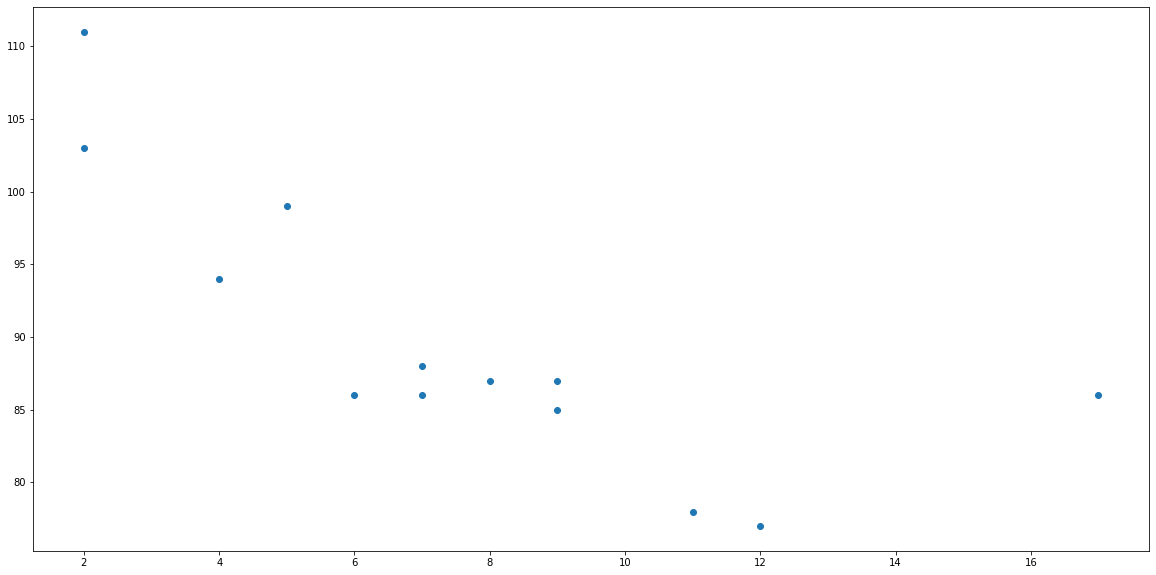